In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import json
import cv2
import numpy as np
import seaborn as sns
import random
import sys
import os 

sys.path.insert(1, '../../mAP')
from AEmain import MAP

sys.path.insert(2,'../../camera_pose_estimation/ArUCo-Markers-Pose-Estimation-Generation-Python/')
from AE_folder_detect import Pose_Detect

sys.path.insert(3,'../../yolo')
from AE_yolo_folder_detect import Folder_Detect

from AE_yolo_folder_detect_res import Folder_Detect_res

2023-07-21 00:35:00.029575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64:/usr/local/cuda-9.0/lib64:
2023-07-21 00:35:00.029602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Calculation flags
`Calculation_Person_Detection` -> Main flag will perform yolo and mAP calculations 

Other flags for specific policy calculations

In [17]:
Calculate_Person_Detection = True
Detection_Sq_OD = False
Detection_Sq_Rand = False
Detection_Sq_Light = False
Detection_RR = False

In [3]:
legend_methods = ["Sq-Perf","Sq-Rand","Sq-Light","Sq-OD","Sq-Pwr","RR"] #original ["Nominal","Sq-Rand","Sq-AVS","Sq-DVS","RR"]

### Matplotlib Set up
Set up of matplotlib settings, such as font size etc. 

In [4]:
# This is for producing type-1 fonts
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
#TODO: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
plt.rcParams['font.family'] = 'sans-serif'
# tick_font_size_base = 15
# label_font_size_base = 18
# marker_size_base = 8
# legend_size_base = 12

high_level_scaling = 0.57

tick_font_size_base = 15*high_level_scaling
label_font_size_base = 18*high_level_scaling
marker_size_base = 9*high_level_scaling
legend_size_base = 12*high_level_scaling

#half-column figure font size = 2* full column figure font size
#TODO: Clean up this logic later.

full_col_scaling = .8
half_col_scaling = 0.50
one_third_col_scaling = 0.4

line_width = '1'


## Calc Power Measurements

In [5]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling

### Calculate power measurments

Analyizes the voltage measurments and then calculates power consumption and power standard variation. For for example look at `power_measurments/power_measurments.ipynb`. 

In [6]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
3403080
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
resolutions = ["mode-1","mode-2","mode-3","mode-4","mode-5","mode-6","mode-7"]
voltages.reverse()
data_frames = [] 
data_frames_res = [] 

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for volt in voltages: 
    df = pd.read_csv( f"./data/{volt}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames.append(df)


#resolutions 
for res in resolutions: 
    df = pd.read_csv( f"./data/{res}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames_res.append(df)
    
    
average_power = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    average_power.append(df["power_total"].mean())
    std_power.append((df["power_total"]*1000).std())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())

average_power = np.array(average_power)
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)
std_power = np.array(std_power)

average_power_res = []
std_power_res = []
average_analog_res = []
average_digital_res = [] 
for df in data_frames_res: 
    average_power_res.append(df["power_total"].mean())
    std_power_res.append((df["power_total"]*1000).std())
    average_analog_res.append(df["power_analog"].mean())
    average_digital_res.append(df["power_digital"].mean())

average_power_res = np.array(average_power_res)
average_analog_res = np.array(average_analog_res)
average_digital_res = np.array(average_digital_res)
std_power_res = np.array(std_power_res)
    
    

### Power Measurment Summary
Power measurement vs analog voltage summary. Found by using `v^2/r` for both analog and digital power rails, and combining to find total power. This was done using `mode_1` (1920x1080, 16:9, 1/10 <= fps <= 30)

In [7]:
ref_power = average_power[-1] 
data_summary = []
data_summary.append(voltages)
data_summary.append(np.asarray(average_power)*1000)
data_summary.append(np.asarray(std_power))
data_summary.append(np.asarray((ref_power - average_power)*1000))
data_summary.append(np.asarray(((ref_power-average_power)/ref_power)*100))
data_summary = np.array(data_summary)
data_summary
df_s = pd.DataFrame(np.transpose(data_summary),columns=["Analog Voltage","Average Power mW","Average Power STD","Delta from Reference Power mW","Percent Savings"])
df_s

Analog Voltage  Average Power mW  Average Power STD  \
0              1.4         31.971844          11.646486   
1              1.5         39.583839          14.381211   
2              1.6         47.772924          17.279823   
3              1.7         56.662783          20.616947   
4              1.8         65.524485          24.424534   
5              1.9         74.281662          28.543713   
6              2.0         82.511428          32.240650   
7              2.1         90.337558          35.906643   
8              2.2         97.791455          40.035979   
9              2.3        105.197454          44.325149   
10             2.4        112.026955          48.108693   
11             2.5        115.487728          49.019819   
12             2.6        116.508072          47.785380   
13             2.7        117.147585          46.588562   
14             2.8        118.273066          45.453048   

    Delta from Reference Power mW  Percent Savings  
0                       86.301222        72.967773  
1                       78.689227        66.531823  
2                       70.500142        59.607943  
3                       61.610283        52.091558  
4                       52.748581        44.598980  
5                       43.991404        37.194777  
6                       35.761638        30.236502  
7                       27.935508        23.619501  
8                       20.481611        17.317224  
9                       13.075612        11.055443  
10                       6.246111         5.281094  
11                       2.785338         2.355006  
12                       1.764994         1.492304  
13                       1.125481         0.951595  
14                       0.000000         0.000000

The power vs sensor mode. Collected in the same way as the measurments above. Note `mode_7` is 480p. Full list of the sensor modes can be found here [https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes](https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes)

In [8]:
ref_power_res = average_power_res[-1] 
data_summary_res = []
data_summary_res.append(resolutions)
data_summary_res.append(np.asarray(average_power_res)*1000)
data_summary_res.append(np.asarray(std_power_res))
data_summary_res.append(np.asarray((ref_power_res - average_power_res)*1000))
data_summary_res.append(np.asarray(((ref_power_res-average_power_res)/ref_power_res)*100))
data_summary_res = np.array(data_summary_res)
df_s_res = pd.DataFrame(np.transpose(data_summary_res),columns=["Analog Voltage","Average Power mW","Average Power STD","Delta from Reference Power mW","Percent Savings"])
df_s_res

Analog Voltage    Average Power mW   Average Power STD  \
0         mode-1  112.50314456849082   42.12873482780069   
1         mode-2  132.27029763207423   41.15705005695018   
2         mode-3  132.71605404095638  40.896129659903195   
3         mode-4  123.50332288670525   46.27011420331416   
4         mode-5  110.86491635584817   45.87211074598893   
5         mode-6   99.14713084788305   43.03976335665374   
6         mode-7   89.18290974941237   36.44213142865845   

  Delta from Reference Power mW      Percent Savings  
0           -23.320234819078454  -26.148770974847128  
1           -43.087387882661865   -48.31350311817536  
2           -43.533144291544005   -48.81332579735755  
3            -34.32041313729288   -38.48317265463411  
4           -21.682006606435795   -24.31184031487452  
5            -9.964221098470672  -11.172792103855219  
6                           0.0                  0.0

In [9]:
# calculate Reduced Resolution power (RR)
# The RR power consumption with 100% duty cycle is that listed above. 
# We want to simulate RR power consumption for a 90% duty cycle. 90% 480p 10% 1080p 
trial = 100000 
low_res = int(trial*.9)
high_res = int(trial*.1)

high_res_power = np.random.normal(loc=float(df_s_res["Average Power mW"][0]), scale=float(df_s_res["Average Power STD"][0]), size=high_res)
low_res_power = np.random.normal(loc=float(df_s_res["Average Power mW"][6]), scale=float(df_s_res["Average Power STD"][6]), size=low_res)

combined_low_res = np.concatenate((low_res_power,high_res_power))

### Generate Power Data look up dictionary

In [10]:
key=[2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
key.reverse()
key= list(map(str,key))
power_data=dict(zip(key,list(tuple(zip(average_power*1000,std_power)))))
power_data['RR'] = (combined_low_res.mean(), combined_low_res.std())
power_data

{'1.4': (31.97184409775719, 11.6464861385476),
 '1.5': (39.58383927898389, 14.381210938581868),
 '1.6': (47.77292435674655, 17.279822953490974),
 '1.7': (56.662782970762116, 20.61694689705907),
 '1.8': (65.5244847792147, 24.424534470486623),
 '1.9': (74.28166248908028, 28.54371340718571),
 '2.0': (82.5114279167174, 32.24064950476923),
 '2.1': (90.33755836186393, 35.90664343040927),
 '2.2': (97.79145494327533, 40.03597943924442),
 '2.3': (105.19745435085278, 44.32514897342224),
 '2.4': (112.02695488414749, 48.108692855798246),
 '2.5': (115.48772794718724, 49.01981873569915),
 '2.6': (116.50807224397641, 47.78538020174051),
 '2.7': (117.1475853240965, 46.58856241591167),
 '2.8': (118.27306627435667, 45.453047655382264),
 'RR': (91.59479316472942, 37.86574028507635)}

# Figure Code
### Figure 3.
Sensor power significantly reduces by lowering its supply voltage. The flat portion above 2.4 V is due to strong voltage regulation inside teh sensor

In [11]:
#plt.title("Total Power vs Analog Voltage",fontsize = label_font_size)
plt.xlabel("Analog Voltage",fontsize = label_font_size)
plt.ylabel("Average Power (mW)",fontsize = label_font_size)
plt.scatter(voltages,average_power*1000, label='Total Power',color="blue")
#plt.plot(voltages,average_digital*1000, label='Digital Power')
#plt.plot(voltages,average_analog*1000, label='Analog Power')
#plt.legend(fontsize=legend_size)
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/AveragePowerVsAnalogVoltage.pdf",format='pdf', dpi=1000, bbox_inches="tight")
#plt.figsave("test.png")

## Figure 5c 
Histogram

/tmp/ipykernel_37591/416585290.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(input1.ravel(),hist=False, kde=True, kde_kws={"lw":1,"label":names[0],'color':colors[0],"linestyle":"-."} )
/tmp/ipykernel_37591/416585290.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distpl

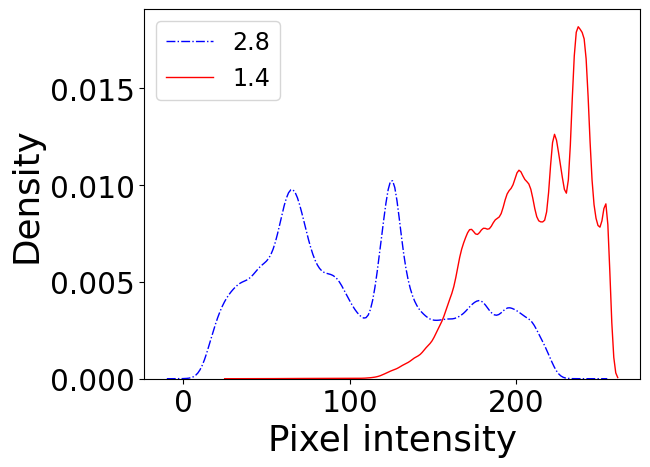

In [12]:
tick_font_size = tick_font_size_base/one_third_col_scaling
label_font_size = label_font_size_base/one_third_col_scaling
marker_size = marker_size_base/one_third_col_scaling
legend_size = legend_size_base/one_third_col_scaling

#input1 = png.read_png_int("input_cropped.png")
#input2 = png.read_png_int("output_cropped.png")
#input1 = cv2.imread('data_c/fig_4/e_2.8_0000.jpg')
#input2 = cv2.imread('data_c/fig_4/e_1.4_0000.jpg')
input1 = cv2.imread('data_c/fig_outdoor/outdoor_2p8.jpg')
input2 = cv2.imread('data_c/fig_outdoor/outdoor_1p4.jpg')
input1 = cv2.cvtColor(input1, cv2.COLOR_BGR2GRAY)
input2 = cv2.cvtColor(input2, cv2.COLOR_BGR2GRAY)

# Assign colors for each airline and the names
colors = ['blue', 'red']
names = ['2.8', '1.4']




plt.figure()         
sns.distplot(input1.ravel(),hist=False, kde=True, kde_kws={"lw":1,"label":names[0],'color':colors[0],"linestyle":"-."} )
ax = sns.distplot(input2.ravel(), hist=False, kde=True, kde_kws={'linewidth':1,"label":names[1],'color':colors[1]})

plt.legend(loc = 0, prop={'size': legend_size})
plt.xlabel('Pixel intensity',  fontsize = label_font_size)
plt.ylabel('Density',  fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/PixelDesnsityHistogram.pdf", format='pdf', dpi=1000, bbox_inches="tight")

### Power Trace Calculations

In [13]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
T = 60 * 6
FS = 9400 #Hz
N = FS * T
#CHANGE -> AVS 
#LIGHT -> DVS
test_sections = [("high",0,60*2), ("mid", 60*2,60*4), ("low",60*4,60*6)]
data_paths = ["random-indoor","random-indoor-cafe","light-indoor","light-indoor-cafe","change-indoor","change-indoor-cafe"]
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
names = ["baseline","random", "random-cafe","light","light-cafe","change","change-cafe","480p"]
names_b = ["random", "random-cafe","light","light-cafe","change","change-cafe"]
baseline_power = 118.272012 / 1000
baseline_std = 45.454833
#adjusted to 90% duty cycle simulated 
res_480_power = 89.18290974941237 
res_480_power = res_480_power*.9 + 118.272012*.1 
res_480_std = 85.90667830669737 
#voltages.reverse()
data_frames = [] 
data_frames_split = []
times = []

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for path in data_paths: 
    df = pd.read_csv( f"./data_c/fig_8/{path}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    entry = {}
    for n,s,f in test_sections:
        start = df[df.isin([int(s*FS)]).any(axis=1)].index.values[0]
        finish = df[df.isin([int(f*FS)]).any(axis=1)].index.values[0]
        #print(n,start,finish)
        entry[n] = df[start:finish]
    data_frames_split.append(entry)
    
    row_max = df[df.isin([int(N)]).any(axis=1)].index.values[0]
    df = df[:row_max]
    data_frames.append(df)
    f = open(f"./data_c/fig_8/{path}.json",)
    times.append(json.load(f))
    f.close()
    

    
average_power = []
energy = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    std_power.append((df["power_total"]*1000).std())
    average_power.append(df["power_total"].mean())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())
    energy.append((np.array(df["power_total"]) * 1/FS).sum())
    
average_power_split = {"high":[],
                       "high-std":[],
                       "mid" :[],
                       "mid-std" :[],
                       "low" :[],
                       "low-std" :[],} 
for df in data_frames_split:
    average_power_split["high"].append(df["high"]["power_total"].mean())
    average_power_split["mid"].append(df["mid"]["power_total"].mean())
    average_power_split["low"].append(df["low"]["power_total"].mean())
    average_power_split["high-std"].append((df["high"]["power_total"]*1000).std())
    average_power_split["mid-std"].append((df["mid"]["power_total"]*1000).std())
    average_power_split["low-std"].append((df["low"]["power_total"]*1000).std())

average_power_split["high"] = np.array([baseline_power] + average_power_split["high"]+ [res_480_power/1000])
average_power_split["mid"] = np.array([baseline_power] + average_power_split["mid"]+ [res_480_power/1000])
average_power_split["low"] = np.array([baseline_power] + average_power_split["low"]+ [res_480_power/1000])
average_power_split["high-std"] = np.array([baseline_std] + average_power_split["high-std"]+ [res_480_std])
average_power_split["mid-std"] = np.array([baseline_std] + average_power_split["mid-std"]+ [res_480_std])
average_power_split["low-std"] = np.array([baseline_std] + average_power_split["low-std"]+ [res_480_std])

average_power = np.array([baseline_power] + average_power + [res_480_power/1000])
# [BASELINE, RANDOM-INDOOR, RANDOM-CAFE, LIGHT INDOOR, LIGHT CAFE, CHANGE INDOOR, CHANGE CAFE, RR] 
std_power = np.array([baseline_std] +std_power+ [res_480_std])
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)

    


## Fig 13 
Entrance detection datset voltage traces

random


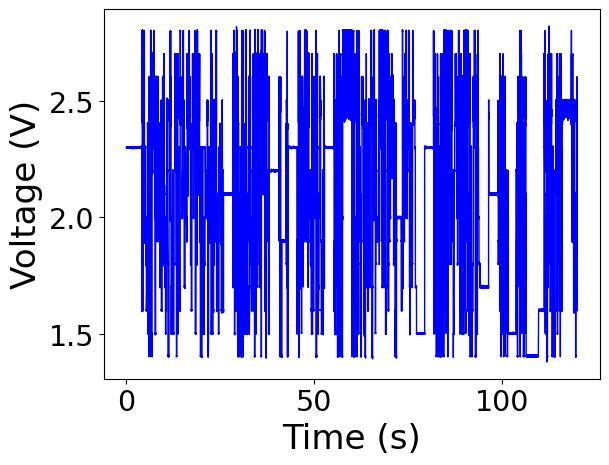

light


change


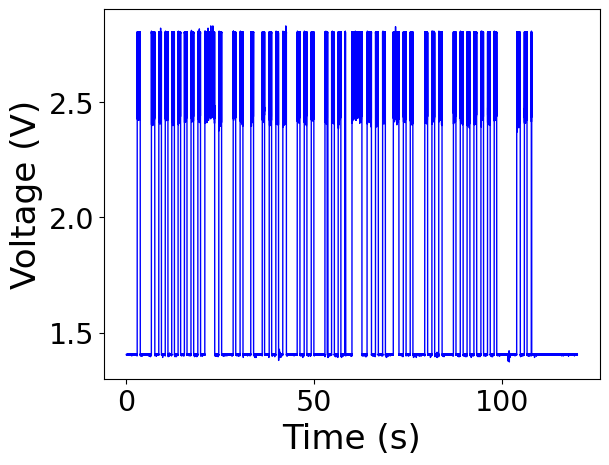

In [14]:

#Voltage vs Time Charts
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

i=0
j = 0 
r = "high"
indexes = [0,2,4]
letters = ['a','b','c']
for idx,i in enumerate(indexes):
    print(names_b[i])
    #plt.title(f"Voltage vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)",fontsize = label_font_size)
    plt.ylabel("Voltage (V)",fontsize = label_font_size)
    plt.tick_params(axis = 'both', labelsize = tick_font_size)
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r][" value ch2"]))),(data_frames_split[i][r][" value ch2"]),color="blue",linewidth=1)
    plt.savefig(f"./figs/VoltageTraces{letters[idx]}_{names_b[i]}.pdf",format='pdf', dpi=1000, bbox_inches="tight")
    plt.show()
    #plt.cla()

    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

### Figure 14
Person tracking dataset

random-cafe


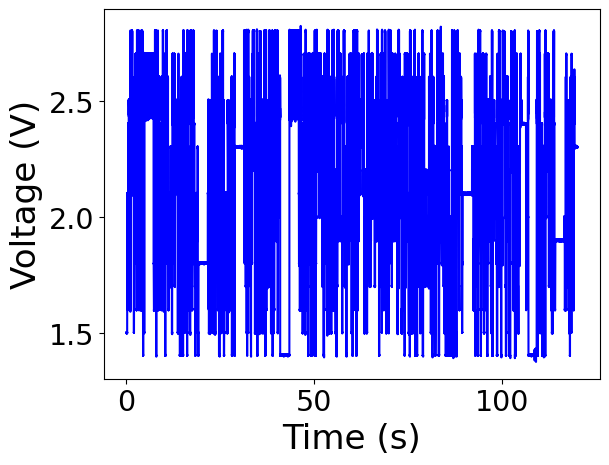

light-cafe


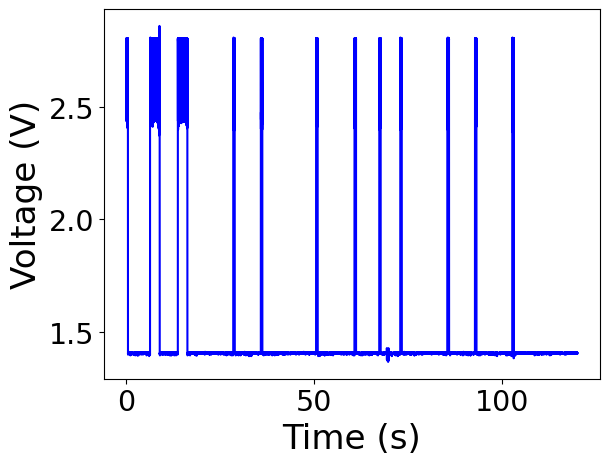

change-cafe


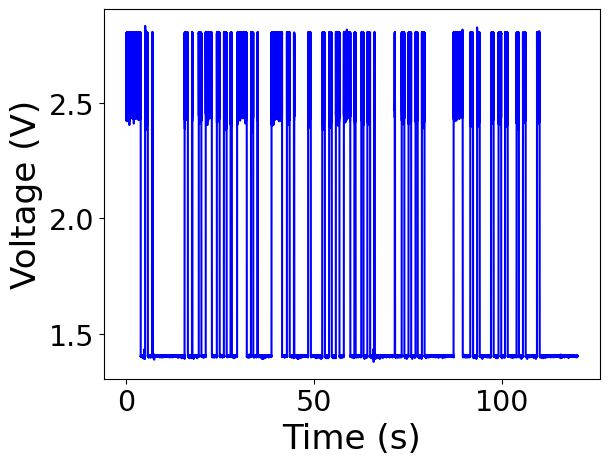

In [15]:
#Trail Entrance 
#Voltage vs Time Charts
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

i=0
j = 0 
r = "high"
indexes = [1,3,5]
letters = ['a','b','c']
for idx,i in enumerate(indexes):
    print(names_b[i])
    #plt.title(f"Voltage vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)",fontsize = label_font_size)
    plt.ylabel("Voltage (V)",fontsize = label_font_size)
    plt.tick_params(axis = 'both', labelsize = tick_font_size)
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r][" value ch2"]))),(data_frames_split[i][r][" value ch2"]),color="blue")
    plt.savefig(f"./figs/VoltageTraces{letters[idx]}_{names_b[i]}.pdf",format='pdf', dpi=1000, bbox_inches="tight")
    #plt.cla()
    plt.show()
    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

## Fig 15 b

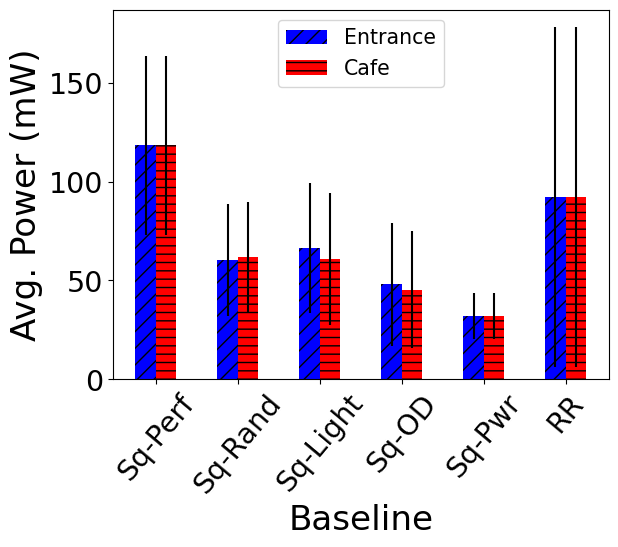

In [16]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

#create data
last = len(average_power_split['high'])-1
indexes_trail = [0,1,3,5,last]
indexes_cafe = [0,2,4,6,last]

x = np.arange(len(indexes_trail)+1)
y1 = np.array([average_power[i] for i in indexes_trail])*1000
y2 = np.array([average_power[i] for i in indexes_cafe])*1000
width = 0.25

l = len(y1)
y1 = y1.tolist()
y2 = y2.tolist()
y1.insert(l-1,.03197184*1000)
y2.insert(l-1,.03197184*1000)
#y1 = y1[0:l-2] + [0.03197184] +y1[l-1]
#y2 = y2[0:l-2] + [0.03197184]+ y2[l-1]
    
e1=[std_power[i] for i in indexes_trail]
e2=[std_power[i] for i in indexes_cafe] 
e1.insert(l-1,11.64648614)
e2.insert(l-1,11.64648614)
# plot data in grouped manner of bar type
plt.bar(x-width/2, y1, width,yerr=e1,hatch='//',fill=True,color="blue")
plt.bar(x+width/2, y2, width,yerr=e2,hatch='--',fill=True, color="red")


plt.xticks(x, legend_methods,fontsize=label_font_size,rotation=50)
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Avg. Power (mW)",fontsize=label_font_size)
plt.legend(["Entrance", "Cafe"],fontsize=legend_size,loc='upper center')
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig(f"./figs/AveragePower_Combo.pdf",format='pdf', dpi=1000, bbox_inches="tight")
plt.show()

## mAP Calculations 
### Person Detection yolo

In [7]:
if Calculate_Person_Detection:
    policies = []
    if Detection_Sq_OD:
        policies.append("change")

    if Detection_Sq_Rand:
        policies.append("random")

    if Detection_Sq_Light:
        policies.append("light")

    detector = Folder_Detect('../../../data/policies-indoor-cafe/',policies)
    detector.detect() 
    
    detector = Folder_Detect('../../../data/policies-indoor/',policies)
    detector.detect() 

    if Detection_RR:
        detector = Folder_Detect_res('../../../data/', ['480p-cafe','480p-indoor'])
        detector.detect()

    

../../yolo/model_data/yolo_weights.h5 model, anchors, and classes loaded.


IndexError: list index out of range

In [18]:
ignore = ['tvmonitor', 'remote', 'refrigerator', 'pottedplant', 'mouse', 'laptop', 'keyboard', 'handbag', 'diningtable', 'cup', 'chair', 'cellphone', 'bottle', 'trafficlight', 'frisbee', 'sportsball', 'bowl', 'suitcase', 'cat']
cafe_data_f = {}
trail_data_f = {}
low_avg = (0.06+0.96+.91)/3 # average values from figure 6


if Calculate_Person_Detection:

    if(Detection_Sq_OD):
        #calculate change(sq-OD)
        change_cafe = MAP("../../data/policies-indoor-cafe/change/input/",ignore)
        cafe_data_f["change"] = change_cafe.evaluate()['person'] #match
        #calculate change(sq-OD)
        change_trail = MAP("../../data/policies-indoor/change/input/",ignore)
        trail_data_f["change"] = change_trail.evaluate()['person'] #match

    if(Detection_Sq_Rand):
        #calculate random (sq-rand)
        random_cafe = MAP("../../data/policies-indoor-cafe/random/input/",ignore)
        cafe_data_f["random"] = random_cafe.evaluate()['person'] #match
        #calculate random (sq-rand)
        random_trail = MAP("../../data/policies-indoor/random/input/",ignore)
        trail_data_f["random"] = random_trail.evaluate()['person'] #match

    if(Detection_Sq_Light):
        #calculate light (sq-light)
        light_cafe = MAP("../../data/policies-indoor-cafe/light/input/",ignore)
        cafe_data_f["light"] = light_cafe.evaluate()['person'] #match
        #calculate light (sq-light)
        light_trail = MAP("../../data/policies-indoor/light/input/",ignore)
        trail_data_f["light"] = light_trail.evaluate()['person'] #match

    if(Detection_RR):
        #480p
        low_res_cafe = MAP("../../data/480p-cafe/input/",ignore)
        cafe_data_f["480p"] = low_res_cafe.evaluate()['person']
        #480p
        low_res_trail = MAP("../../data/480p-indoor/input/",ignore)
        trail_data_f["480p"] = low_res_trail.evaluate()['person']



if(not Detection_RR):
    cafe_data_f["480p"] = (0.9516207043984821,0.10205751059181614)
    trail_data_f["480p"] = (0.894733275840828,0.2297413082694629)

if(not Detection_Sq_Light):
    cafe_data_f["light"] = (0.8760960823630117,0.13849649413799872)
    trail_data_f["light"] = (0.7889213016984312,0.333345162223047)

if(not Detection_Sq_Rand):
    cafe_data_f["random"] = (0.9172058062010485,0.14742101216614742)
    trail_data_f["random"] = (0.907248694844305,0.21682268493274745)

if(not Detection_Sq_OD):
    cafe_data_f["change"] = (0.9589767251102225,0.10585652485089583)
    trail_data_f["change"] = (0.8927751937984496,0.24752208390426758)

low_avg = (0.06+0.96+.91)/3
#calcualte basline
cafe_data_f["2.8"] = (1,0)
#calculate low 
cafe_data_f["low"] = (low_avg,0)
#Trail 
#calcualte basline
trail_data_f["baseline"] = (1,0)
#calculate low 
trail_data_f["low"] = (low_avg,0)

"""
    cafe_data_f = {"2.8":(1,0),
                 "random":(0.9172058062010485,0.14742101216614742),
                  "light":(0.8760960823630117,0.13849649413799872),
                  "change":(0.9589767251102225,0.10585652485089583),
                   "low":(low_avg,0),
                  "480p":(0.9516207043984821,0.10205751059181614)}

    trail_data_f = {"baseline":(1,0),
                 "random":(0.907248694844305,0.21682268493274745),
                 "light":(0.7889213016984312,0.333345162223047),
                "change":(0.8927751937984496,0.24752208390426758),
                    "low":(low_avg,0),
                 "480p":(0.894733275840828,0.2297413082694629)}
"""
print()

## Figure 15 a

In [19]:
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

#create data
last = len(average_power_split['high'])-1
indexes = [0,2,4,6,8,last]

x = np.arange(len(indexes))
y1 = list(map(lambda x:x[0],cafe_data_f.values()))
y2 = list(map(lambda x:x[0],trail_data_f.values()))
width = 0.25


# plot data in grouped manner of bar type
e1= list(map(lambda x:x[1],trail_data_f.values()))
e1 = [e1,np.array(e1) - ((np.array(e1)+np.array(y2)) - 1)]
e1[0][4] = 0
e1[1][4] = 0 

e2= list(map(lambda x:x[1],trail_data_f.values()))
e2 = [e2,np.array(e2) - ((np.array(e2)+np.array(y1)) - 1)]
e2[0][4] = 0
e2[1][4] = 0 

plt.bar(np.array(list(range(0,len(cafe_data_f.keys()))))+width/2, y2, width,yerr=e1,hatch='--',fill=True, color="blue")
plt.bar(np.array(list(range(0,len(cafe_data_f.keys()))))-width/2, y1, width,yerr=e2,hatch='//',fill=True,color="red")

#plt.bar(x+width, y3, width,yerr=[average_power_split['low-std'][i] for i in indexes],hatch='..',fill=False)


plt.xticks(x, legend_methods,fontsize=label_font_size,rotation=50)
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("mAP",fontsize=label_font_size)
plt.legend(["Entrance", "Cafe"],fontsize=legend_size,loc='upper left')
plt.axis('tight')
plt.ylim(0,1.5)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.show()

## Figure 16

### Simulation
Simulation using initial caputured datset to test different marker tracking senarios

#### Calculation of translation and rotational error from marker tracking 

In [20]:
#calculate pose result
calculate_pose = True 
if(calculate_pose):
    voltages = ["2.8","2.0","1.8","1.4"]
    distance = ["close","far","mid"]
    data_path = "../../../data/pose"
    Pose = Pose_Detect(data_path,voltages,distance,True)
    calculated_pose_result = Pose.detect()
    # parse to individual variables
    data_close_r = calculated_pose_result['rotation_results']['close']
    data_close_t = calculated_pose_result['translation_results']['close']
    data_far_r = calculated_pose_result['rotation_results']['far']
    data_far_t = calculated_pose_result['translation_results']['far']

else:
    #pre-calcualted values 
    data_close_r = {'2.8': (0.08261930092869332, 0.0015528753078621),
     '2.0': (0.0695689909712865, 0.0005179286725771192),
     '1.8': (0.07266679243080937, 0.0006425159381182825),
     '1.4': (0.23785900809175697, 0.25597532764703707),
     'RR' :  (0.8639920755843253, 1.0027330353245312)}

    data_close_t = {'2.8': (0.005083347899818022, 6.718520727600731e-07),
     '2.0': (0.005069542914280222, 5.173212809572066e-07),
     '1.8': (0.005143351745347177, 7.017299451493388e-07),
     '1.4': (0.016574853326425856, 0.0012063953411780494),
     'RR' : (0.1014849022828926, 0.019209536805246768)}

    data_far_r = {'2.8': (1.0500292455288864, 1.016043567960141),
     '2.0': (1.2760954479244546, 1.6101380754679737),
     '1.8': (0.994294563303928, 0.9579993972018489),
     '1.4': (0.4054499307184435, 0.47018999015668134),
      'RR':  (1.5537341924410757, 1.4451069778329855)}

    data_far_t = {'2.8': (0.1014849022828926, 0.019209536805246768),
     '2.0': (0.13143820726294475, 0.02113855413856242),
     '1.8': (0.10144285847348644, 0.01939287583138232),
     '1.4': (0.037941987677959324, 0.009169461716809747),
      "RR":  (0.1014849022828926, 0.019209536805246768)}

    

In [21]:
#simulation 
#6 minutes 
#half close 
frame_n = 60*6*24
voltages = ["2.8","2.0","1.8","1.4"]


In [22]:
power_avg = 0
power_var = 0
t_avg = 0
t_var = 0 

power = []
t = [] 
r = []

results = {"nominal":{"p":0,"t":0, "r":0},
          "random":{"p":0,"t":0, "r":0},
          "distance":{"p":0,"t":0, "r":0},
           "low":{"p":0,"t":0, "r":0},
          "RR":{"p":0,"t":0, "r":0}}

#random policy
for n in range(0,frame_n): 
    volt = random.choice(voltages)
    power.append(np.random.normal(loc=power_data[volt][0], scale=(power_data[volt][1]), size=1)) 
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=np.sqrt(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))

power = np.array(power)
t = np.array(t)
r = np.array(r)
    

In [23]:
results["random"]["p"] = (power.mean(),power.std())
results["random"]["r"] = (r.mean(),r.std())
results["random"]["t"] = (t.mean(),t.std())

In [24]:
#low policy
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "1.4"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["low"]["p"] = (power.mean(),power.std())
results["low"]["t"] = (t.mean(),t.std())
results["low"]["r"] = (r.mean(),t.std())

In [25]:
power = []
t = [] 
r = []

#if close low else high
for n in range(0,frame_n): 
   # volt = random.choice(voltages)
     
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
        volt = "1.4"
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
        volt = "2.8"
    power.append(np.random.normal(loc=power_data[volt][0], scale=(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)

results["distance"]["p"] = (power.mean(),power.std())
results["distance"]["t"] = (t.mean(),t.std())
results["distance"]["r"] = (r.mean(),t.std())

In [26]:
#Nominal
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "2.8"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["nominal"]["p"] = (power.mean(),power.std())
results["nominal"]["t"] = (t.mean(),t.std())
results["nominal"]["r"] = (r.mean(),t.std())

In [27]:
#RR
power = []
t = [] 
r = []

for n in range(0,frame_n): 
   # volt = random.choice(voltages)
    volt = "RR"
    #print(power[-1])
    if(random.random() < 0.5): 
        #close 
        t.append(np.random.normal(loc=data_close_t[volt][0], scale=(data_close_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    else: 
        t.append(np.random.normal(loc=data_far_t[volt][0], scale=(data_far_t[volt][1]), size=1))
        r.append(np.random.normal(loc=data_close_r[volt][0], scale=(data_close_r[volt][1]), size=1))
    power.append(np.random.normal(loc=power_data[volt][0], scale=(power_data[volt][1]), size=1))
    
    
power = np.array(power)
t = np.array(t)
r = np.array(r)
results["RR"]["p"] = (power.mean(),power.std())
results["RR"]["t"] = (t.mean(),t.std())
results["RR"]["r"] = (r.mean(),t.std())

In [28]:
results

{'nominal': {'p': (118.17747009662023, 45.68355471081163),
  't': (0.12191376484300828, 0.06605473981285086),
  'r': (0.8501009675884321, 0.06605473981285086)},
 'random': {'p': (74.15873235526134, 43.433015281170526),
  't': (0.09384872912090486, 0.09906355655394664),
  'r': (0.5916195147209292, 0.5426795543805019)},
 'distance': {'p': (74.44209148453685, 53.82058201791578),
  't': (0.10173151660512261, 0.056226138450550044),
  'r': (0.673509449810747, 0.056226138450550044)},
 'low': {'p': (31.85900851931261, 11.649484232389632),
  't': (0.08215837871772066, 0.03517143689046648),
  'r': (0.5053540463499127, 0.03517143689046648)},
 'RR': {'p': (92.07841911631778, 38.25191989196697),
  't': (0.12215218066065256, 0.06612831605122921),
  'r': (0.8436857715550861, 0.06612831605122921)}}

In [29]:
#translational norm 
legend_marker = ["Sq-Perf","Sq-Rand","Sq-Dist","Sq-Pwr","RR"]
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Error (m)",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["t"][0] for k in results.keys() ],yerr=[results[k]["t"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.ylim(0,.25)
plt.savefig(f"./figs/translational_norm.pdf",format='pdf', dpi=1000, bbox_inches="tight")

## Figure 16 a
Rotational norm vs policy

In [30]:
#rotational norm 
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("L2 Norm",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["r"][0] for k in results.keys() ],yerr=[results[k]["r"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker, fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.ylim(0,1)
plt.savefig(f"./figs/rotational_norm.pdf",format='pdf', dpi=1000, bbox_inches="tight")

## Figure 16b

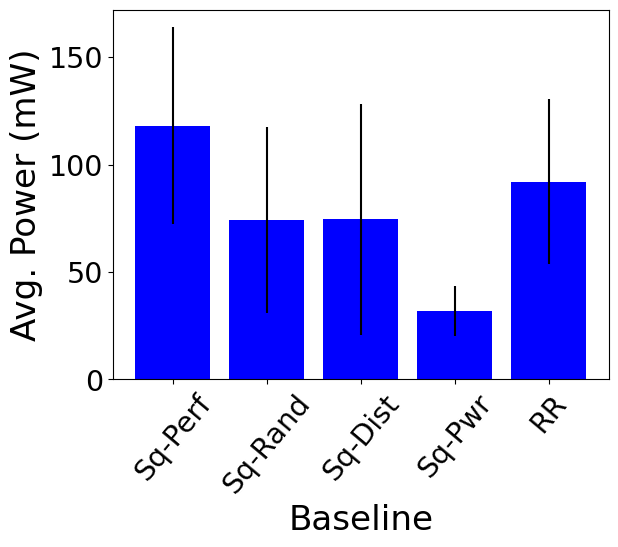

In [31]:
plt.xlabel("Baseline",fontsize=label_font_size)
plt.ylabel("Avg. Power (mW)",fontsize=label_font_size)
x = list(range(0,len(results.keys())))
plt.bar(x,[results[k]["p"][0] for k in results.keys() ],yerr=[results[k]["p"][1] for k in results.keys()],fill=True,color="blue" )
plt.xticks(x, legend_marker,fontsize=label_font_size,rotation=50)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
#plt.ylim(0,1)
plt.savefig(f"./figs/pose_power.pdf",format='pdf', dpi=1000, bbox_inches="tight")

## Fig 13

In [32]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
f = 1338.53
T = 1/f 
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
resolutions = ["mode-1","mode-2","mode-3","mode-4","mode-5","mode-6","mode-7"]
voltages.reverse()
data_frames = [] 
data_frames_res = [] 

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for volt in voltages: 
    df = pd.read_csv( f"./data/{volt}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames.append(df)


#resolutions 
for res in resolutions: 
    df = pd.read_csv( f"./data/{res}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    data_frames_res.append(df)
    
    
#plot settings
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling
num_s = 127
off_set = 17
plt.xlabel("Time (s)",fontsize=label_font_size)
plt.ylabel("Power (mW)",fontsize=label_font_size)
plt.plot(np.linspace(0,num_s,num_s)*T,data_frames[-1]["power_total"][0:num_s]*1000,color="red",linestyle="--",label="2.8")
plt.plot(np.linspace(0,num_s,num_s)*T, data_frames[0]["power_total"][off_set:num_s+off_set]*1000,color="blue",label ="1.4")
plt.legend(fontsize=legend_size)
plt.savefig(f"./figs/power_traces.pdf",format='pdf', dpi=1000, bbox_inches="tight")

### Figure 4a 
Dark Signal (DN) vs voltage

**calculated using matlab script**

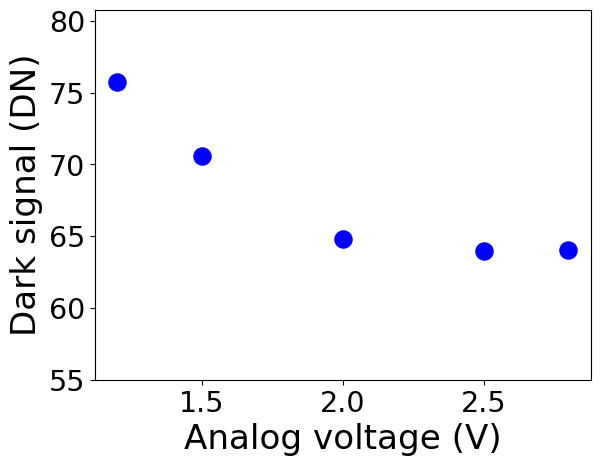

In [40]:
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/half_col_scaling
label_font_size = label_font_size_base*high_level_scaling/half_col_scaling
marker_size = marker_size_base*high_level_scaling/half_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/half_col_scaling

voltage = [1.2, 1.5, 2, 2.5, 2.8]
signal = [75.7467, 70.6017, 64.8243, 63.9944, 64.0212]

plt.figure()
plt.plot(voltage, signal, linestyle = 'None', marker = 'o', color="blue", markersize = marker_size)
plt.axis('tight')
# plt.locator_params(axis="x", nbins=10)
# plt.xlim(1, 3)
plt.ylim(55, max(signal)+5)
plt.xlabel('Analog voltage (V)', fontsize = label_font_size)
plt.ylabel('Dark signal (DN)', fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./DarkSignal.pdf", format='pdf', dpi=1000, bbox_inches="tight")

#plt.close()

### Figure 4b


In [13]:
voltage = [1.2, 1.5, 2, 2.5, 2.8]
noise = [6.8569, 3.819, 1.7277, 2.036, 2.0035]

plt.figure()
plt.plot(voltage, noise, linestyle = 'None', marker = 'x', color="blue", markersize = marker_size)
plt.axis('tight')
# plt.locator_params(axis="x", nbins=10)
#plt.xlim(0, max(voltage)+1)
#plt.ylim(0, max(noise)+1)
plt.xlabel('Analog voltage (V)', fontsize = label_font_size)
plt.ylabel('Noise (DN)', fontsize = label_font_size)
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/TemporalNoise.pdf",format='pdf', dpi=1000, bbox_inches="tight")


## Figure 6
mAP vs light level

The remaining figures plot measurment data that we are not able to reproduce

In [16]:
ignore = ['tvmonitor', 'remote', 'refrigerator', 'pottedplant', 'mouse', 'laptop', 'keyboard', 'handbag', 'diningtable', 'cup', 'chair', 'cellphone', 'bottle', 'trafficlight', 'frisbee', 'sportsball', 'bowl', 'suitcase', 'cat']

#Use Pre-computed values 
map_bright = [0.9,0.85,0.97,.8988,0.92,0.91]

map_mid = [0.96,0.89,0.94,.8078,0.73,0.96]

map_low = [0.56,0.383,0,.14,0,0.06]  

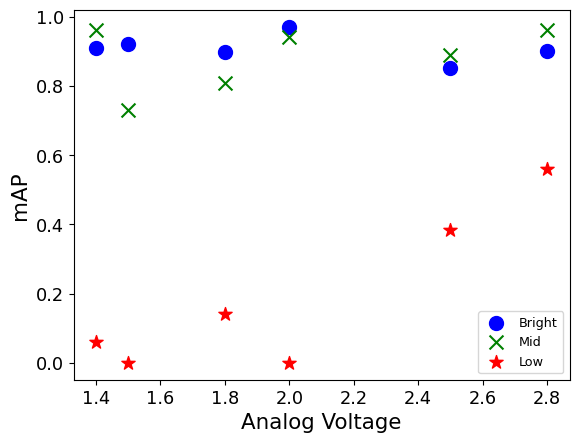

In [17]:
high_level_scaling = 1.2
tick_font_size = tick_font_size_base*high_level_scaling/full_col_scaling
label_font_size = label_font_size_base*high_level_scaling/full_col_scaling
marker_size = marker_size_base*high_level_scaling/full_col_scaling
legend_size = legend_size_base*high_level_scaling*0.9/full_col_scaling

voltages = [2.8,2.5,2.0,1.8,1.5,1.4]
map_bright = [0.9,0.85,0.97,.8988,0.92,0.91]

map_mid = [0.96,0.89,0.94,.8078,0.73,0.96]

map_low = [0.56,0.383,0,.14,0,0.06]

#plt.title("Total Power vs Analog Voltage",fontsize = label_font_size)
plt.xlabel("Analog Voltage",fontsize = label_font_size)
plt.ylabel("mAP",fontsize = label_font_size)
size_conc = 100
plt.scatter(voltages,map_bright, label='Bright',marker = 'o',color="blue",s=size_conc)
plt.scatter(voltages,map_mid,label='Mid',marker = 'x',color="green",s=size_conc)
plt.scatter(voltages,map_low, label='Low',marker = '*',color="red",s=size_conc)
plt.legend(fontsize=legend_size)
plt.axis('tight')
plt.tick_params(axis = 'both', labelsize = tick_font_size)
plt.savefig("./figs/mAPvsAnalogVoltage.pdf",format='pdf', dpi=1000, bbox_inches="tight")
#plt.figsave("test.png")